<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Open-file--and-review-common-data" data-toc-modified-id="Open-file--and-review-common-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Open file  and review common data</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Calculations-and-adding-results-to-the-table" data-toc-modified-id="Calculations-and-adding-results-to-the-table-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculations and adding results to the table</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory data analysis</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Real Estate Ads Research (St. Petersburg)


We have data of Yanderx.RealEstate service - the archive of apartment selling advertisements in Saint-Petersburg and nearby satelite towns during few  years. We have to figure out the market value of real estate. Our task is to define the parameters. This will allows to build the automated system to track anomalies and fraudulent activity.

There are two types of data available for each selling apartment. The first one was written by users, the second one -generated automatically based on map data. For example: distance to center, nearest airport, park, river or lake.


## Open file  and review common data

In [64]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt 


In [65]:

data=pd.read_csv('/datasets/real_estate_data.csv', sep = '\\t', engine='python')

def unique_list_all():
    for c in data:
        print('column: {}'.format(c))
        print(data[c].unique())
print(data.isna().sum())

data['rooms'].unique()
zero_rooms = data.query('rooms == 0').sort_values(by ='total_area',ascending = False)

data['floor'].unique()
zero_floors = data.query('floors_total.isnull()', engine='python')



total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


### Conclusion

The file has been checked.
As a result of this researh, the following issues have been identified:

1. Incorrect data type: we have to prepare data types and cast to int the following column types: floors_total, balcony, parks_around3000, ponds_around3000, days_exposition.
is_apartment colunt type we are gonna cast to boolean.

airports_nearest,cityCenters_nearest, parks_nearest и ponds_nearest column types we will cast to int as well. 
first_day_exposition we have to cast to datetime and get rid of actual time part (h, m, s) as is evquals 0:00:00 in all the rows anyway. Reduse the int size/range for rest of the parameters.


2. Missing values have been detected:
 kitchen_area,living_area,ceiling_height,cityCenters_nearest,days_exposition,airports_nearest,parks_nearest,ponds_nearest.

We are going to fill by median:
airports_nearest,parks_nearest,ponds_nearest.

living_area, kitchen_area - we have to calculate the average dependecy of total_area coefficient for each parameter and fill up all the missed values with this coefficient, multiplied by total_area

floors_total:
Assume that missing values "floors total" match real floors.
balcony:
We are going to replace missing values by 0, assuming that there is no balcony for missing values.

locality_name -  for this case we have only 49 missing values - We are going to remove it.


## Data preprocessing

In [66]:
def to_type(data_to_write, column, target_type):
    data_to_write[column] = data_to_write[column].astype(target_type)

#replace missing values by median
def replace_nan_by_median(data_to_write, to_column, by_column):
    medians = data_to_write.groupby(by_column)[to_column].median()
    for column, median in medians.items():
        data_to_write.loc[data_to_write[by_column] == column, to_column] = data_to_write.loc[data_to_write[by_column] == column, to_column].fillna(median)

data['balcony'] = data['balcony'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(0)

data['locality_name'] = data['locality_name'].dropna(how='any')

data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('посёлок', '')
data['locality_name'] = data['locality_name'].str.replace('городского типа', '')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', '')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ', '')
data['locality_name'] = data['locality_name'].str.replace('городской', '')
data['locality_name'] = data['locality_name'].str.replace('коттеджный', '')
data['locality_name'] = data['locality_name'].str.replace('село', '')
data['locality_name'] = data['locality_name'].str.replace('деревня', '')
data['locality_name'] = data['locality_name'].str.replace('станция', '')
data['locality_name'] = data['locality_name'].str.replace('станции', '')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной', '')
data['locality_name'] = data['locality_name'].str.strip()


area_rooms_gr = data.groupby(['total_area','rooms'])
print('>>>> living_area', data['living_area'].isna().sum())
data['living_area'] = data['living_area'].fillna(area_rooms_gr['living_area'].transform(lambda group: group.mean() / (group.name[0])) * data['total_area'])
print('>>>> living_area', data['living_area'].isna().sum())
data['living_area'] = data['living_area'].fillna(data['living_area'].mean())
print('>>>> living_area', data['living_area'].isna().sum())

print('>>>> kitchen_area', data['kitchen_area'].isna().sum())
data['kitchen_area'] = data['kitchen_area'].fillna(area_rooms_gr['kitchen_area'].transform(lambda group: group.mean() / (group.name[0])) * data['total_area'])
print('>>>> kitchen_area', data['kitchen_area'].isna().sum())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].mean())
print('>>>> kitchen_area', data['kitchen_area'].isna().sum())

#replace_nan_by_median(data, 'ceiling_height', 'is_apartment')
data['ceiling_height'] = data['ceiling_height'].fillna(0)

replace_nan_by_median(data, 'airports_nearest', 'is_apartment')

#replace_nan_by_median(data, 'cityCenters_nearest', 'is_apartment')

replace_nan_by_median(data, 'parks_nearest', 'is_apartment')
replace_nan_by_median(data, 'ponds_nearest', 'is_apartment')

#replace_nan_by_median(data, 'days_exposition', 'is_apartment')
data['days_exposition'] = data['days_exposition'].fillna(-1)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1)

data['floors_total'] = data['floors_total'].fillna(data['floor'])
floors_total_test = data.query('floors_total.isnull()', engine='python')

to_type(data, 'total_images', 'uint8')
to_type(data, 'last_price', 'uint32')
to_type(data, 'total_area', 'uint16')


data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

to_type(data, 'rooms', 'uint8')
to_type(data, 'ceiling_height', 'float32')
to_type(data, 'floors_total', 'uint8')
to_type(data, 'living_area', 'uint16')
to_type(data, 'floor', 'uint8')
to_type(data, 'is_apartment', 'bool')
to_type(data, 'studio', 'bool')
to_type(data, 'open_plan', 'bool')

to_type(data, 'kitchen_area', 'uint16')
to_type(data, 'balcony', 'bool')

to_type(data, 'airports_nearest', 'uint32')
to_type(data, 'cityCenters_nearest', 'int32')
to_type(data, 'parks_around3000', 'uint8')
to_type(data, 'parks_nearest', 'uint16')
to_type(data, 'ponds_around3000', 'uint8')
to_type(data, 'ponds_nearest', 'uint16')
to_type(data, 'days_exposition', 'int32')

data['locality_name'].unique()

>>>> living_area 1903
>>>> living_area 212
>>>> living_area 0
>>>> kitchen_area 2278
>>>> kitchen_area 421
>>>> kitchen_area 0


array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'фёдоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное', 'понтонный', 'сясьстрой',
       'старая', 'лесколово', 'новый свет', 'сланцы', 'путилово',
       'ивангород', 'шлиссельбург', 'никольское', 'зеленогорск',
       'сосновый бор', 'оржицы', 'кальтино', 'романовка', 'бугры',
       'рощино', 'кириши', 'луга', 'волосово', 'отрадное', 'павлово',
       'оредеж', 'копорье', 'молодёжное', 'тихвин', 'победа', 'нурма',
       'синявино', 'тосно', 'стрельна', 'бокситогорск', 'але

### Conclusion

Выполнили преобработку данных
изменили типы данных, уменьшив размерность.

parks_nearest,ponds_nearest,airports_nearest -We have been filled it by median values;

living_area,kitchen_area - для каждого параметра считается средний коэффициент отношения к total_area. Пропуски заполняются умножение данного коэффициента на total_area.

ceiling_height, cityCenters_nearest, days_exposition - We have filled it by marker values.
floors_total:

We have considered,that missing values "floors total" match real floors.

balcony:

We have replaced missing values by 0, assuming that there is no balcony for missing values.
kitchen_area - после заполнения living_area по медианному значению, примем, что для пропущенных значений kitchen_area равна разнице между total_area и living_area.
locality_name - missing values have been removed.

locality_name has been transformed by common style  - we have kept just locality name, transformed by low register as well.

## Calculations and adding results to the table

In [67]:
#add new column with sque meters cost
data['price_sq_m'] = data['last_price'] / data['total_area']
to_type(data, 'price_sq_m', 'uint32')

#publication day
data['day_name'] = data['first_day_exposition'].dt.day_name()
data['month_name'] = data['first_day_exposition'].dt.month_name()
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek


#конвертируем индекс этажа в тип
def floor_to_type(floor, floor_max):
    if floor == 1:
        return "first"
    if floor == floor_max:
        return "last"
    return "other"

data['floor_type'] = data.apply(lambda row: floor_to_type(row['floor'], row['floors_total']), axis=1)

#living area -> common area
data['living_to_common_area'] = data['living_area'] / data['total_area']
#kitchen -> common area
data['kitchen_to_common_area'] = data['kitchen_area'] / data['total_area']
#add column with distance to center (kilometers)
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
to_type(data, 'cityCenters_nearest_km', 'uint16')
                                        
display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,price_sq_m,day_name,month_name,month,year,day_of_week,floor_type,living_to_common_area,kitchen_to_common_area,cityCenters_nearest_km
0,20,13000000,108,2019-03-07,3,2.70,16,51,8,False,...,120370,Thursday,March,3,2019,3,other,0.472222,0.231481,16
1,7,3350000,40,2018-12-04,1,0.00,11,18,1,False,...,83750,Tuesday,December,12,2018,1,first,0.450000,0.275000,19
2,10,5196000,56,2015-08-20,2,0.00,5,34,4,False,...,92785,Thursday,August,8,2015,3,other,0.607143,0.142857,14
3,0,64900000,159,2015-07-24,3,0.00,14,54,9,False,...,408176,Friday,July,7,2015,4,other,0.339623,0.094340,7
4,2,10000000,100,2018-06-19,2,3.03,14,32,13,False,...,100000,Tuesday,June,6,2018,1,other,0.320000,0.410000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133,2017-03-21,3,3.70,5,73,3,False,...,72932,Tuesday,March,3,2017,1,other,0.548872,0.097744,4
23695,14,3100000,59,2018-01-15,3,0.00,5,38,4,False,...,52542,Monday,January,1,2018,0,other,0.644068,0.135593,0
23696,18,2500000,56,2018-02-11,2,0.00,3,29,1,False,...,44642,Sunday,February,2,2018,6,first,0.517857,0.160714,0
23697,13,11475000,76,2017-03-28,2,3.00,17,34,12,False,...,150986,Tuesday,March,3,2017,1,other,0.447368,0.302632,10


### Conclusion

We have calculated parametrs price_sq_m,day_name,floor_type,living_to_common_area, kitchen_to_common_area.
We have added as well  month_name,year, cityCenters_nearest_km, It is need during preparing a dependency research.

In next step we need to check outlier in data for basic parameters of apartments:
price, area, number of rooms,ceiling height.
We can use describe method to discover the parameteres.



## Exploratory data analysis

Determine outliers

In [68]:
#top limit room count
rooms_limit= data['rooms'].quantile(q=0.75)+1.5*(data['rooms'].quantile(q=0.75)-data['rooms'].quantile(q=0.25))
print(rooms_limit)

6.0


In [69]:
#top price limit 
price_limit_top= data['last_price'].quantile(q=0.75)+1.5*(data['last_price'].quantile(q=0.75)-data['last_price'].quantile(q=0.25))
print(price_limit_top)
#bottom price limit 
price_limit_bottom= data['last_price'].quantile(q=0.75)-1.5*(data['last_price'].quantile(q=0.75)-data['last_price'].quantile(q=0.25))
print(price_limit_bottom)

11900000.0
1700000.0


In [70]:
print('for area')
area_limit_top= data['total_area'].quantile(q=0.75)+1.5*(data['total_area'].quantile(q=0.75)-data['total_area'].quantile(q=0.25))
print(area_limit_top)
area_limit_bottom= data['total_area'].quantile(q=0.75)-1.5*(data['total_area'].quantile(q=0.75)-data['total_area'].quantile(q=0.25))
print(area_limit_bottom)

for area
112.5
25.5


In [71]:
#for ceiling height
ceiling_limit_top= data['ceiling_height'].quantile(q=0.75)+1.5*(data['ceiling_height'].quantile(q=0.75)-data['ceiling_height'].quantile(q=0.25))
print(ceiling_limit_top)
ceiling_limit_bottom= data['ceiling_height'].quantile(q=0.75)-1.5*(data['ceiling_height'].quantile(q=0.75)-data['ceiling_height'].quantile(q=0.25))
print(ceiling_limit_bottom)

6.7500001192092896
-1.350000023841858


In [72]:
#top limit for day

days_exposition_top= data['days_exposition'].quantile(q=0.75)+1.5*(data['days_exposition'].quantile(q=0.75)-data['days_exposition'].quantile(q=0.25))
print(days_exposition_top)


464.5


In [73]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23699.000000,2.369900e+04,23699.000000,23699.000000
mean,60.120511,6.541549e+06,2.070636,1.696182
std,35.665822,1.088701e+07,1.078405,1.672495
min,12.000000,1.219000e+04,0.000000,0.000000
25%,40.000000,3.400000e+06,1.000000,0.000000
50%,52.000000,4.650000e+06,2.000000,2.500000
75%,69.000000,6.800000e+06,3.000000,2.700000
max,900.000000,7.630000e+08,19.000000,100.000000


Parameters were  researched. Outliers was determined . Detected anomalous values - it is outliers. For example - ceiling height couldn't be 1 or 100 meters.

1. We are going to keep in datasheet all records where apartment costs is less than 11,9 millions rubles
2. We are going to keep in datasheet all records where apartment area is less than 112,5 meters.
3. We are going to keep in datasheet all records where apartment has less than 6 rooms.

Total of 23699 records left 21453. We lost 9,5%. This is acceptable in our case.

Next we filter the dataframe by the received values and build charts.

In [74]:
#filter data
data = data[(data['rooms'] <= rooms_limit)]
data = data[(data['last_price'] <= price_limit_top)]
data = data[(data['total_area'] <= area_limit_top)]
data = data[(data['ceiling_height'] <= ceiling_limit_top)]
data = data[(data['days_exposition'] <= days_exposition_top)]

days_exposition_valid = data[(data['days_exposition'] > 0)]

In [75]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height','days_exposition']].describe()

,total_area,last_price,rooms,ceiling_height,days_exposition
count,19740.000000,1.974000e+04,19740.000000,19740.000000,19740.000000
mean,52.038095,4.776952e+06,1.900355,1.613966,103.053799
std,17.451406,2.166994e+06,0.882906,1.324740,110.732321
min,12.000000,1.219000e+04,0.000000,0.000000,-1.000000
25%,38.000000,3.300000e+06,1.000000,0.000000,20.000000
50%,48.000000,4.380000e+06,2.000000,2.500000,60.000000
75%,62.000000,5.900000e+06,3.000000,2.650000,151.000000
max,112.000000,1.190000e+07,6.000000,5.800000,464.000000


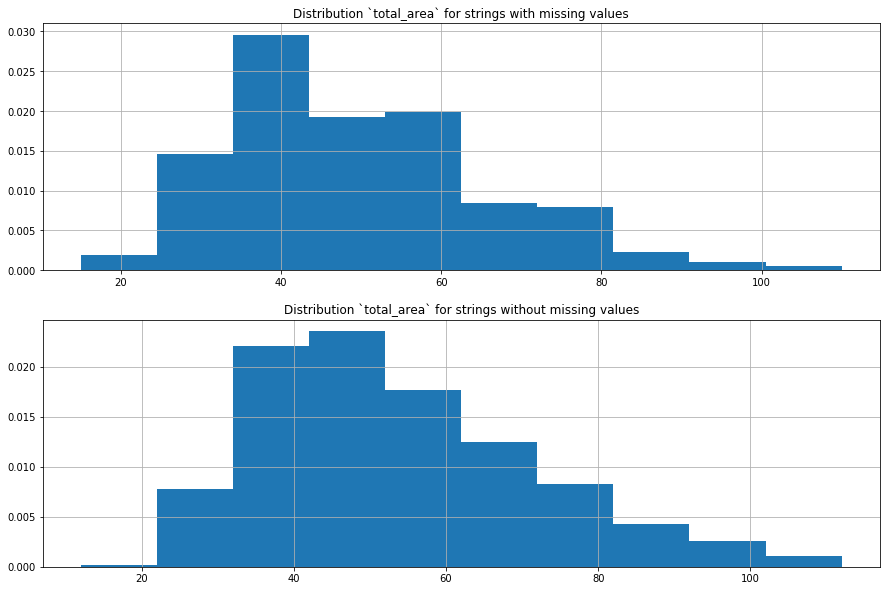

In [76]:
#plot a histogram for area

fig, axes = plt.subplots(2,1,figsize=(15,10))
data[data['cityCenters_nearest'] < 0]['total_area'].hist(density=True,ax=axes[0])
data[data['cityCenters_nearest'] >= 0]['total_area'].hist(density=True,ax=axes[1])

axes[0].set_title('Distribution `total_area` for strings with missing values')
axes[1].set_title('Distribution `total_area` for strings without missing values')

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537933be50>]],
      dtype=object)

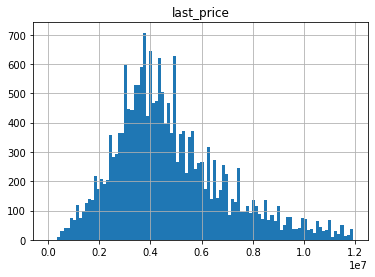

In [77]:
#plot a histogram for price
data.hist('last_price',bins=100)
#days_exposition_valid.hist('last_price',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537976fdd0>]],
      dtype=object)

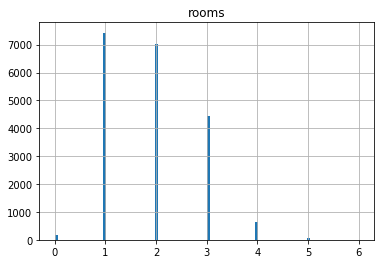

In [78]:
#plot a histogram rooms count
data.hist('rooms',bins=100)

Plot histogram by **days_exposition** and could see peak values (this is our -1 marker that we replaced the missing values with). Second histogram was plot upon data without marker. We can see that there is no peak.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537901ab90>]],
      dtype=object)

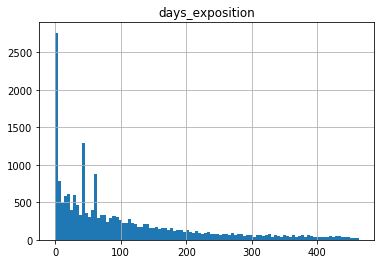

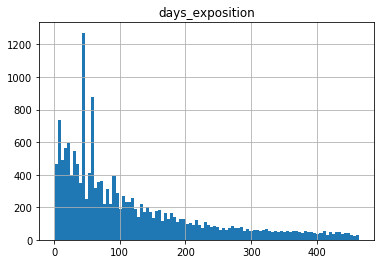

In [79]:
data.hist('days_exposition',bins=100)
days_exposition_valid.hist('days_exposition',bins=100)

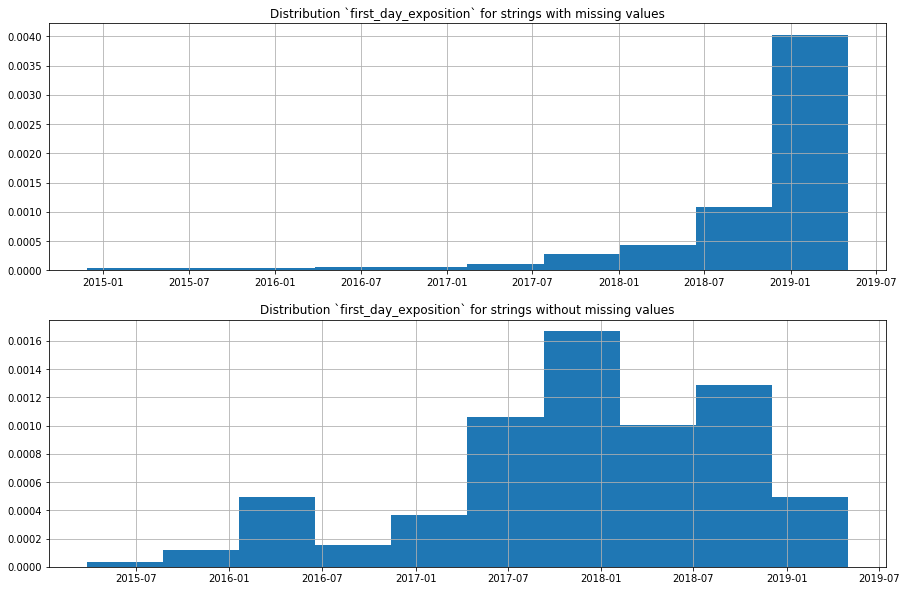

In [80]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
data[data['days_exposition'] == -1]['first_day_exposition'].hist(density=True,ax=axes[0])
data[data['days_exposition'] != -1]['first_day_exposition'].hist(density=True,ax=axes[1])

axes[0].set_title('Distribution `first_day_exposition` for strings with missing values')
axes[1].set_title('Distribution `first_day_exposition` for strings without missing values')

plt.show()

In [81]:
days_exposition_valid['days_exposition'].describe()

count    17136.000000
mean       118.865896
std        110.587537
min          1.000000
25%         39.000000
50%         78.000000
75%        170.000000
max        464.000000
Name: days_exposition, dtype: float64

There are several peak of values **days_exposition**. A lot of ads have been removed at the same time at least twice. Suppose these ads were removed by the system.
If apartment was sold during 15 days - we can consider that it was very fast (too long - more than 430 days). Apartments is usually got sold in 1.5 month average.

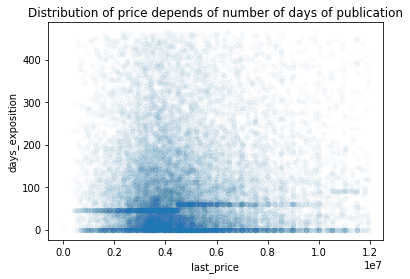

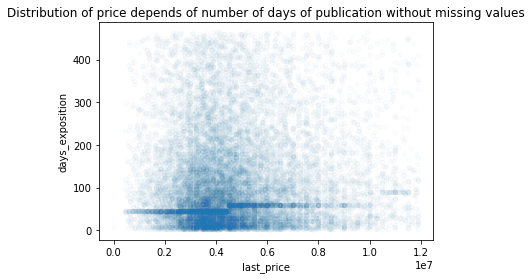

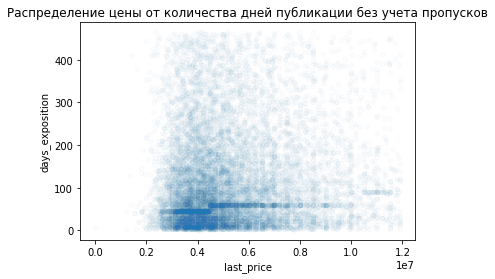

In [82]:
data.plot(x ='last_price', y='days_exposition', title = "Distribution of price depends of number of days of publication", kind = 'scatter', alpha = 0.02)
days_exposition_valid.plot(x ='last_price', y='days_exposition',  title = "Distribution of price depends of number of days of publication without missing values",kind = 'scatter', alpha = 0.02)
days_exposition_valid[days_exposition_valid['cityCenters_nearest'] >= 0].plot(x ='last_price', y='days_exposition',  title = "Распределение цены от количества дней публикации без учета пропусков",kind = 'scatter', alpha = 0.02)


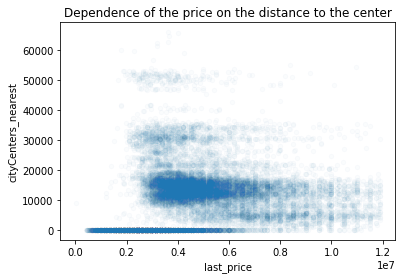

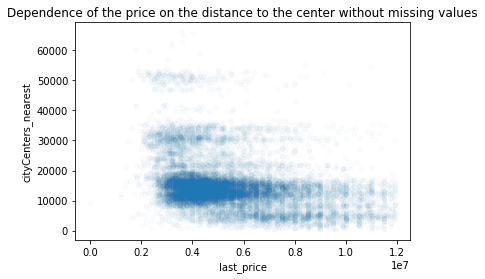

In [83]:
data.plot(x ='last_price', y='cityCenters_nearest', title = "Dependence of the price on the distance to the center", kind = 'scatter', alpha = 0.02)
data[data['cityCenters_nearest'] >= 0].plot(x ='last_price', y='cityCenters_nearest',  title = "Dependence of the price on the distance to the center without missing values",kind = 'scatter', alpha = 0.02)

,cityCenters_nearest,rooms,total_area
cityCenters_nearest,1.000000,-0.002386,0.014991
rooms,-0.002386,1.000000,0.833412
total_area,0.014991,0.833412,1.000000


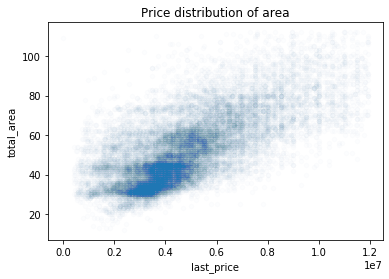

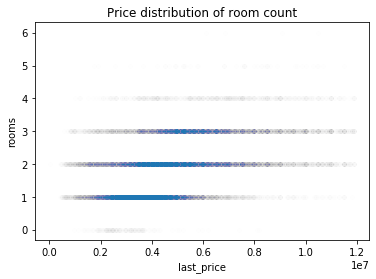

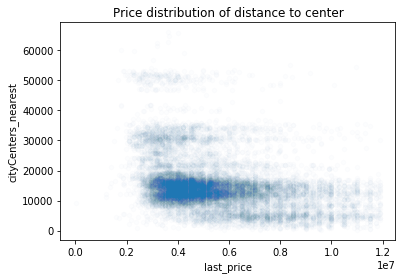

In [117]:
pt = pd.pivot_table(data, index='last_price', values=['total_area', 'rooms', 'cityCenters_nearest'])
display(pt.corr())
#pd.plotting.scatter_matrix(pt, figsize=(9, 9))

#print("normal graphs")
data.plot(x ='last_price', y='total_area',title = "Price distribution of area", kind = 'scatter', alpha = 0.01)
data.plot(x ='last_price', y='rooms',title = "Price distribution of room count", kind = 'scatter', alpha = 0.002)
data[data['cityCenters_nearest'] >= 0].plot(x ='last_price', y='cityCenters_nearest',title = "Price distribution of distance to center",  kind = 'scatter', alpha = 0.01)
#days_exposition_valid.plot(x ='last_price', y='cityCenters_nearest', kind = 'scatter', alpha = 0.01)


We can observe general pattern: prices are getting higher depending on the area, number of rooms and distance from the center.

In [85]:
#method for grouping
def group_by_and_add_price(source, group_by, sort_by):
    gr = source.groupby([group_by])
    gr_counts = gr.size().to_frame(name='count', ).sort_values(by = sort_by, ascending=False)
    
    gr_counts['mean_price'] = round(gr['last_price'].mean())
    to_type(gr_counts, 'mean_price', 'uint32')

    gr_counts['median_price'] = round(gr['last_price'].median())
    to_type(gr_counts, 'median_price', 'uint32')
    
    gr_counts['mean_price_sq_m'] = round(gr['price_sq_m'].median())
    to_type(gr_counts, 'mean_price_sq_m', 'uint32')
    
    return gr_counts

,count,mean_price,median_price,mean_price_sq_m
year,,,,
2019,2596,5092567,4800000,101851
2018,7848,4742663,4350000,94444
2017,7041,4708928,4250000,90625
2016,1859,4701880,4250000,90163
2015,389,4921632,4500000,89024
2014,7,6491429,7500000,106344


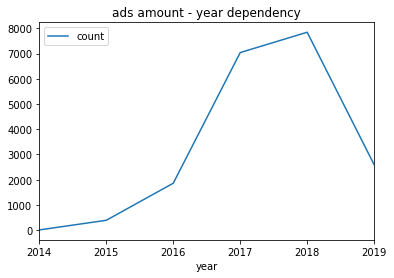

In [118]:
#Number of ads by year
year_gr_counts = group_by_and_add_price(data, 'year', 'year')
year_gr_counts.plot(y='count',title = "ads amount - year dependency", alpha = 1)
year_gr_counts.head(10)

In [87]:
year_2019_data = data[(data['year'] == 2019)]
year_2019_data['month_name'].unique()

array(['April', 'January', 'March', 'February', 'May'], dtype=object)

The number of ads is growing every year. The Yandex.real estate service was launched in the Leningrad region in October 2014, that is why in that year there were fewer ads. We have data for 2019 only from January to May, so it is logical that there are fewer announcements for 2019 than in the previous year. 

,count,mean_price,median_price,mean_price_sq_m
month,,,,
12,1327,4785707,4400000,91891
11,1988,4806327,4400000,93429
10,1828,4758610,4315000,92682
9,1654,4821930,4365502,93612
8,1481,4799758,4350000,95000
7,1401,4777019,4300000,93750
6,1435,4587970,4150000,90350
5,1009,4744954,4300000,91489
4,2011,4884523,4500000,95161


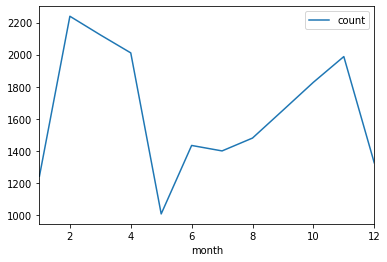

In [88]:
#price by month when ads were added
month_gr_counts = group_by_and_add_price(data, 'month', 'month')

month_gr_counts.plot(y='count', alpha = 1)
month_gr_counts.head(12)

There are the largest number of ads on February. The fewest number of ads were published on December, January and May - most likely due to the fact that these months have the largest number of non-working days.

,count,mean_price,median_price,mean_price_sq_m
day_of_week,,,,
6,1438,4695769,4315000,92956
5,1643,4694440,4350000,91836
4,3366,4767571,4350000,93125
3,3517,4782945,4350000,93103
2,3282,4795691,4400000,93993
1,3484,4825542,4400000,93939
0,3010,4787591,4400000,93518


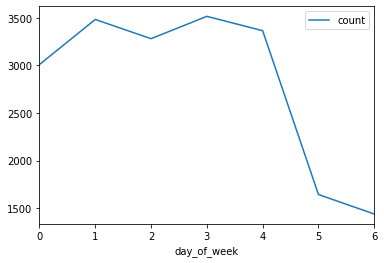

In [89]:
#Количество объявлений от дня создания объявления
day_gr = group_by_and_add_price(data, 'day_of_week', 'day_of_week')

day_gr.plot(y='count', alpha = 1)
day_gr.head(10)

The fewest number of ads were published on Saturdays and Sundays.

,count,mean_price,median_price,mean_price_sq_m
floor_type,,,,
other,14475,4974845,4525000,96717
last,2750,4401516,4000000,85454
first,2515,4048504,3770000,81012


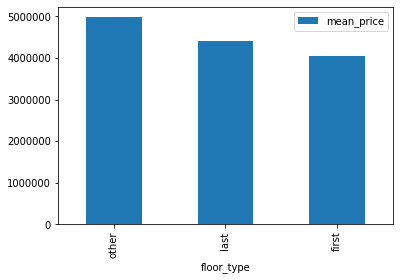

In [90]:
floor_type_gr = group_by_and_add_price(data, 'floor_type', 'count')
floor_type_gr.plot.bar(y='mean_price', alpha = 1)
floor_type_gr.head(10)


Apartments on the first floor is cheaper. Apartments on the last floor is most expensive then on the first floor. Apartments on the middle floors are more expensive than apartments on the first and top floors. 

In [116]:
#define number of ads for each item
#sort by amount
locality_name_counts = group_by_and_add_price(data, 'locality_name', 'count')

#average distance to center
locality_name_counts['mean_center_distance'] = round(data.groupby(['locality_name'])['cityCenters_nearest_km'].mean())
to_type(locality_name_counts, 'mean_center_distance', 'uint32')

locality_name_counts.head(10)

,count,mean_price,median_price,mean_price_sq_m,mean_center_distance
locality_name,,,,,
санкт-петербург,12514,5586996,5100000,102756,12
мурино,547,3644394,3400000,87179,0
кудрово,429,4351168,3900000,96774,0
шушары,411,4074859,3950000,77049,24
всеволожск,357,3731193,3500000,65789,0
колпино,315,3800756,3600000,74468,32
пушкин,308,5299488,4950000,99994,29
парголово,306,4477276,4100000,91858,20
гатчина,276,3435777,3095000,67924,0


There ara the largest number of ads in Saint-Petersburg and its closest suburbs.

In [92]:
#sort by average price
locality_name_mean = locality_name_counts.sort_values(by = 'mean_price_sq_m', ascending=False)

#print highest price
locality_name_mean.head()

,count,mean_price,median_price,mean_price_sq_m,mean_center_distance
locality_name,,,,,
лисий нос,2,4827500,4827500,114316,27
санкт-петербург,12514,5586996,5100000,102756,12
сестрорецк,147,5729756,5250000,101612,35
зеленогорск,21,4814648,4250000,100000,55
пушкин,308,5299488,4950000,99994,29


There is the most expensive accommodations in the elite village of Lisiy Nos and in St. Petersburg and its environmentally friendly countryside district.

In [93]:
#print lowest price
locality_name_mean.tail()

,count,mean_price,median_price,mean_price_sq_m,mean_center_distance
locality_name,,,,,
совхозный,2,517500,517500,12628,0
выскатка,2,585000,585000,12335,0
вахнова кара,1,450000,450000,11842,0
свирь,2,575000,575000,11481,0
старополье,3,460000,450000,11000,0


There is the cheapest hoising in remote towns and villages. 

In [94]:
#group by  distance to center
spb_data = data[(data['locality_name'] == 'санкт-петербург')]
#spb_data['locality_name'].unique()
cityCenters_nearest_km_counts = group_by_and_add_price(spb_data, 'cityCenters_nearest_km', 'cityCenters_nearest_km')

In [95]:
cityCenters_nearest_km_counts.head()

,count,mean_price,median_price,mean_price_sq_m
cityCenters_nearest_km,,,,
29,4,4087500,4525000,66029
28,7,5026429,4990000,79372
27,1,2250000,2250000,70312
26,51,4010386,3340000,90389
25,26,4052840,3794881,94814


In [96]:
cityCenters_nearest_km_counts.tail()

,count,mean_price,median_price,mean_price_sq_m
cityCenters_nearest_km,,,,
4,370,7397074,7300000,112000
3,211,7189814,7100000,108000
2,142,7836387,8200000,115190
1,72,7924069,8100000,113933
0,50,6896372,6500000,114712


closer to city center - higher apartment price

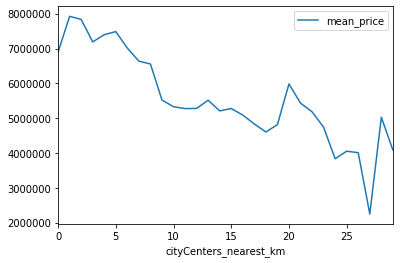

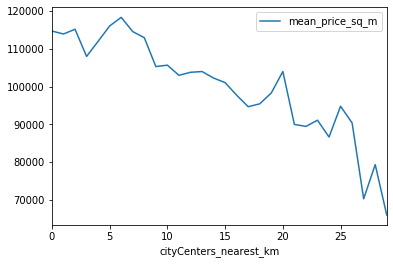

In [97]:
#determine the dependence of distance to center on cost
cityCenters_nearest_km_counts.plot(y='mean_price', alpha = 1)
cityCenters_nearest_km_counts.plot(y='mean_price_sq_m', alpha = 1)

The charts show that the price stops growing at around 8 km. 

In [98]:
center_threshold = 8
distance_to_center_filtred = spb_data[(spb_data['cityCenters_nearest_km'] <= center_threshold)]
distance_to_center_filtred.count()
#distance_to_center_filtred['locality_name'].unique()

total_images              2382
last_price                2382
total_area                2382
first_day_exposition      2382
rooms                     2382
ceiling_height            2382
floors_total              2382
living_area               2382
floor                     2382
is_apartment              2382
studio                    2382
open_plan                 2382
kitchen_area              2382
balcony                   2382
locality_name             2382
airports_nearest          2382
cityCenters_nearest       2382
parks_around3000          2382
parks_nearest             2382
ponds_around3000          2382
ponds_nearest             2382
days_exposition           2382
price_sq_m                2382
day_name                  2382
month_name                2382
month                     2382
year                      2382
day_of_week               2382
floor_type                2382
living_to_common_area     2382
kitchen_to_common_area    2382
cityCenters_nearest_km    2382
dtype: i

,count,mean_price,median_price,mean_price_sq_m
cityCenters_nearest_km,,,,
8,414,6555960,6200000,112952
7,272,6638124,6300000,114564
6,361,7011300,6750000,118341
5,490,7486473,7400000,116064
4,370,7397074,7300000,112000
3,211,7189814,7100000,108000
2,142,7836387,8200000,115190
1,72,7924069,8100000,113933
0,50,6896372,6500000,114712


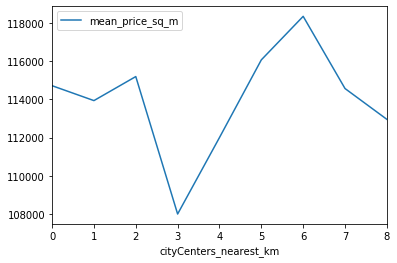

In [99]:
distance_to_center_filtred_gr = group_by_and_add_price(distance_to_center_filtred, 'cityCenters_nearest_km', 'cityCenters_nearest_km')
distance_to_center_filtred_gr.plot(y='mean_price_sq_m')
distance_to_center_filtred_gr.head(100)

Inside that 8 km radius from center, apartment prices are chaning without any noticeable dependency from city center.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53797758d0>]],
      dtype=object)

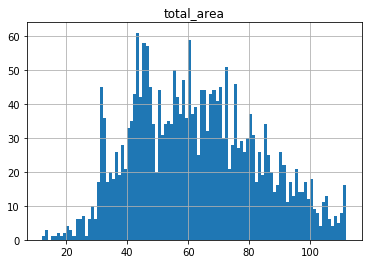

In [100]:
#area for city centr
distance_to_center_filtred.hist('total_area',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537863fc10>]],
      dtype=object)

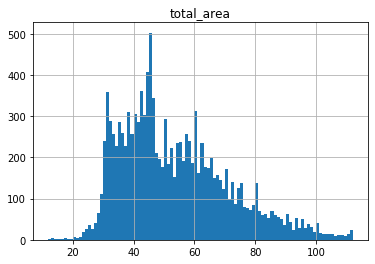

In [101]:
#area for city
spb_data.hist('total_area',bins=100)

The distribution of apartments by area didn't change much depending on the distance to the center. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537951f090>]],
      dtype=object)

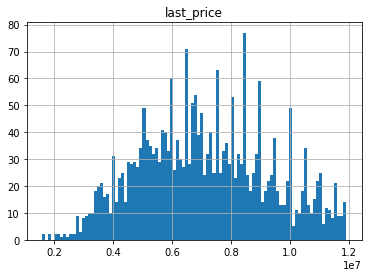

In [102]:
#price for city center 
distance_to_center_filtred.hist('last_price',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5378c1f590>]],
      dtype=object)

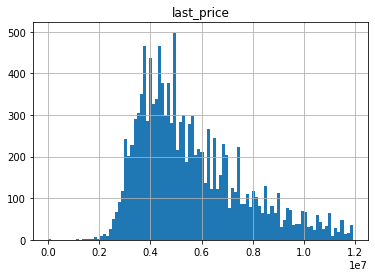

In [103]:
#price for city
spb_data.hist('last_price',bins=100)

Histogram shows that there are more apartments with high price in the city center.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53792e74d0>]],
      dtype=object)

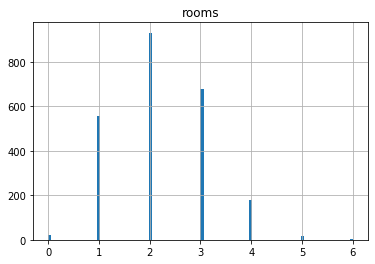

In [104]:
#rooms count for city center
distance_to_center_filtred.hist('rooms',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537976f450>]],
      dtype=object)

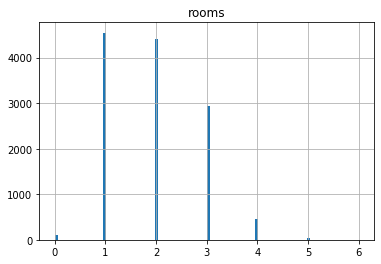

In [105]:
#rooms count for whole city
spb_data.hist('rooms',bins=100)

There are more 2-rooms apartments in city center, while in the whole city approximately the same amount of 1-room and 2-room apartments.

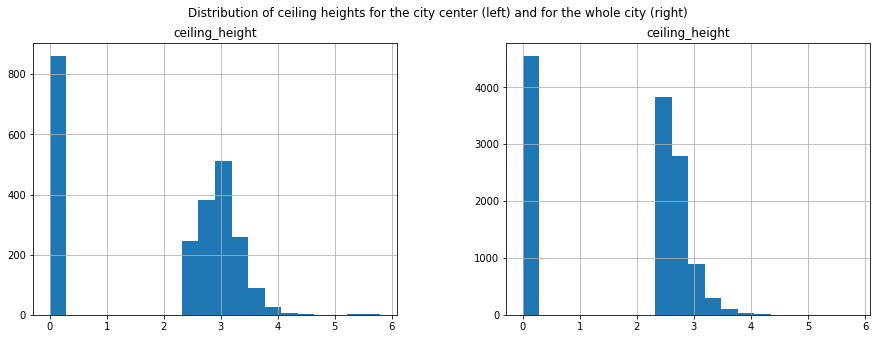

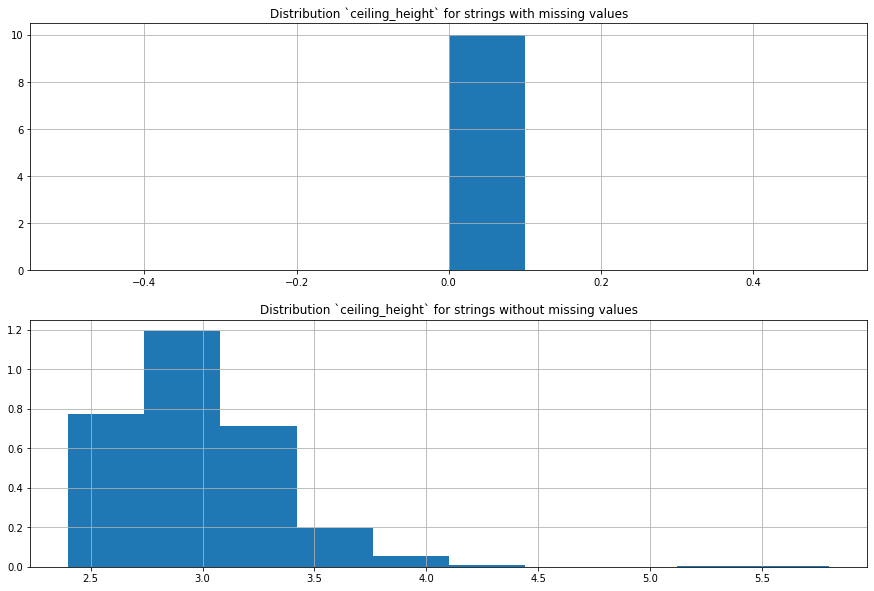

In [106]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribution of ceiling heights for the city center (left) and for the whole city (right)')
distance_to_center_filtred.hist('ceiling_height',bins=20,ax=ax1)
spb_data.hist('ceiling_height',bins=20, ax=ax2)
#ax1.plot(x, y, ax1)
#ax2.plot(x, -y)
plt.show()

fig, axes = plt.subplots(2,1,figsize=(15,10))
distance_to_center_filtred[distance_to_center_filtred['ceiling_height'] == 0]['ceiling_height'].hist(density=True,ax=axes[0])
distance_to_center_filtred[distance_to_center_filtred['ceiling_height'] > 0]['ceiling_height'].hist(density=True,ax=axes[1])

axes[0].set_title('Distribution `ceiling_height` for strings with missing values')
axes[1].set_title('Distribution `ceiling_height` for strings without missing values')

plt.show()


Ceilings are higher in city center. Probable reason - there are many historical buildings in the city center.

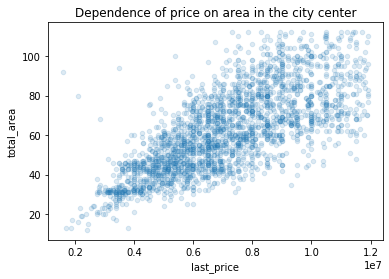

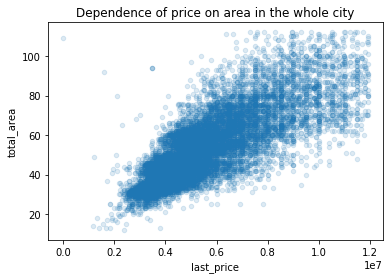

In [113]:
distance_to_center_filtred.plot(x ='last_price', y='total_area', title= "Dependence of price on area in the city center",kind = 'scatter', alpha = 0.15)

spb_data.plot(x ='last_price', y='total_area', title="Dependence of price on area in the whole city",kind = 'scatter', alpha = 0.15)


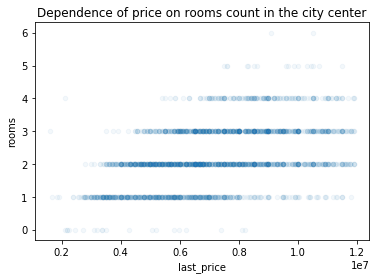

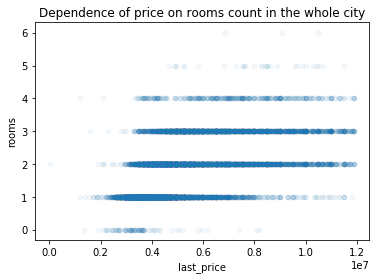

In [115]:
distance_to_center_filtred.plot(x ='last_price', y='rooms',title= "Dependence of price on rooms count in the city center", kind = 'scatter', alpha = 0.05)
spb_data.plot(x ='last_price', y='rooms',title= "Dependence of price on rooms count in the whole city", kind = 'scatter', alpha = 0.05)

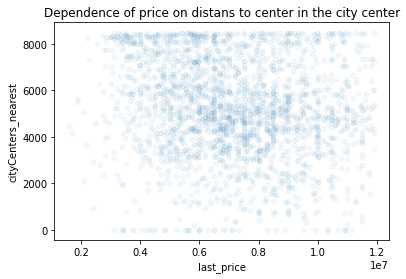

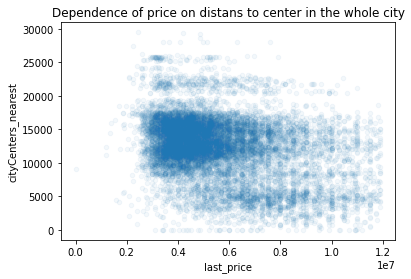

In [109]:

distance_to_center_filtred.plot(x ='last_price', y='cityCenters_nearest',title= "Dependence of price on distans to center in the city center",kind = 'scatter', alpha = 0.05)


spb_data.plot(x ='last_price', y='cityCenters_nearest', title= "Dependence of price on distans to center in the whole city",kind = 'scatter', alpha = 0.05)


,count,mean_price,median_price,mean_price_sq_m
floor_type,,,,
other,1674,7332413,7270000,118181
last,385,7133881,7000000,109062
first,323,6130875,5890000,105236


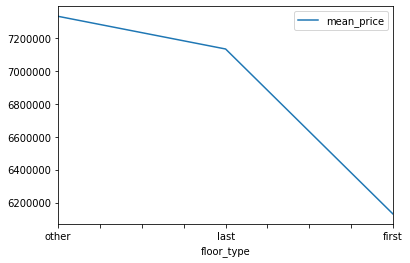

In [110]:
#Dependence of price on floor in the city center
floor_type_gr1 = group_by_and_add_price(distance_to_center_filtred, 'floor_type', 'count')
floor_type_gr1.plot(y='mean_price', alpha = 1)
floor_type_gr1.head()

,count,mean_price,median_price,mean_price_sq_m
floor_type,,,,
other,9698,5674699,5190000,104743
last,1469,5525318,4950000,99827
first,1347,5022823,4626540,92857


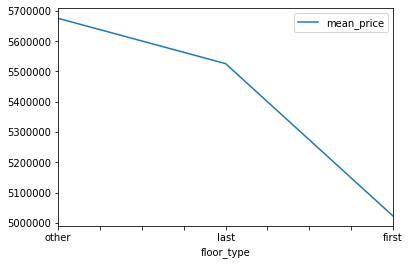

In [111]:
#Dependence of price on floor in the whole city
floor_type_gr = group_by_and_add_price(spb_data, 'floor_type', 'count')
floor_type_gr.plot(y='mean_price', alpha = 1)
floor_type_gr.head()

Conclusions are the same, in general. 
Apartment price is getting higher with increasing of rooms count and area. We can consider, that apartment price distribution is more even in 8km radius from center.
First floor apartments is cheaper. Last floor apartments is more expencive than on the first floor. Apartments on averege floors is more expencive that first and last floor apartments. This distribution is the same as the rest part of the city.

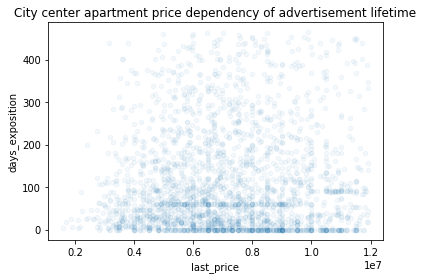

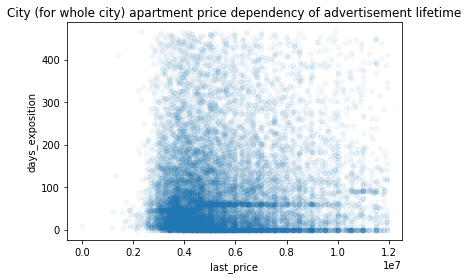

In [114]:
#цена от даты Центр
distance_to_center_filtred.plot(x ='last_price', y='days_exposition', title= "City center apartment price dependency of advertisement lifetime",kind = 'scatter', alpha = 0.05)
#цена от даты Город
spb_data.plot(x ='last_price', y='days_exposition',title= "City (for whole city) apartment price dependency of advertisement lifetime", kind = 'scatter', alpha = 0.05)

## Summary


There are the largest number of ads in Saint-Petersburg and its closest suburbs.
The amount of published advertisements depends of weekday, as well as of month.There are the largest number of ads on February. The fewest number of ads were published on December, January and May - most likely due to the fact that these months have the largest number of non-working days.The fewest number of ads were published on Saturdays and Sundays.

The number of ads is growing every year. The Yandex.real estate service was launched in the Leningrad region in October 2014, that is why in that year there were fewer ads. We have data for 2019 only from January to May, so it is logical that there are fewer announcements for 2019 than in the previous year. 
City center have been defined within 8 km radius
The apartment price depends  of many factors such as of distance to center, area and as well as of floor.
There is the most expensive accommodations in the elite village of Lisiy Nos and in St. Petersburg and its environmentally friendly countryside district. There is the cheapest hoising in remote towns and villages.

Apartments on the first floor is cheaper. Apartments on the last floor is most expensive then on the first floor. Apartments on the middle floors are more expensive than apartments on the first and top floors.
Ceilings are higher in city center. Probable reason - there are many historical buildings in the city center.
We can observe general pattern: prices are getting higher depending on the area, number of rooms and distance from the center.
A lot of ads have been removed at the same time at least twice. Suppose these ads were removed by the system. If apartment was sold during 15 days - we can consider that it was very fast (too long - more than 430 days). Apartments is usually got sold in 1.5 month average.
Data is not full. We have to add user identifier, private or real estate agent advertisement, and a building type as well.